In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CVAE(nn.Module):
    def __init__(self, input_shape, num_features, latent_dim):
        super(CVAE, self).__init__()
        self.input_shape = input_shape
        self.num_features = num_features
        self.latent_dim = latent_dim

        # Define the encoder
        self.conv1 = nn.Conv2d(input_shape[0], 32, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.fc1 = nn.Linear(128 * 27 * 22, 512)
        self.fc2_mu = nn.Linear(512, latent_dim)
        self.fc2_logvar = nn.Linear(512, latent_dim)

        # Define the decoder
        self.fc3 = nn.Linear(latent_dim + num_features, 512)
        self.fc4 = nn.Linear(512, 128 * 27 * 22)
        self.deconv1 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.deconv3 = nn.ConvTranspose2d(32, input_shape[0], kernel_size=4, stride=2, padding=1)

    def _get_conv_output_size(self):
        # Calculate the output size after convolutions
        x = torch.zeros(1, *self.input_shape)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        return x.numel()

    def encode(self, x, features):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        mu = self.fc2_mu(x)
        logvar = self.fc2_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, features):
        x = torch.cat([z, features], dim=1)
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = x.view(x.size(0), 128, 27, 22)  # Reshape to (batch_size, 128, 27, 22)
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = torch.sigmoid(self.deconv3(x))  # Use sigmoid for the output layer
        return x

    def forward(self, x, features):
        mu, logvar = self.encode(x, features)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z, features)
        return recon_x, mu, logvar


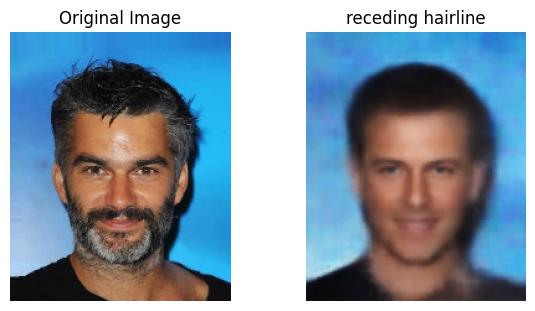

In [10]:
import torch
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

# Define transformation
transform = transforms.Compose([
    transforms.Resize((218, 178)),
    transforms.ToTensor(),
])

# Define the path to the image
# image_path = 'E:/projects/VAE/data/img_align_celeba_png/test/163164.png'
image_path = 'E:/projects/VAE/data/img_align_celeba_png/test/180344.png'
# image_path = 'E:/projects/VAE/data/img_align_celeba_png/test/162907.png'#good for bald[0,1,0,0,0,1,0,0,0,1]

# Load and preprocess the image
image = Image.open(image_path).convert('RGB')
image = transform(image).unsqueeze(0).cuda()  # Add batch dimension and move to GPU

# Define the new condition vector
# Attractive,Bald,Smiling,Wearing_Lipstick,Young,Eyeglasses,Heavy_Makeup,Mustache,No_Beard,Receding_Hairline
conditions = [0,0,0,0,0,0,0,0,1,0]  # Example conditions
# conditions = [1,1,1,1,1,1,1,1,1,1]  # Example conditions
condition_tensor = torch.tensor(conditions, dtype=torch.float32).unsqueeze(0).cuda()

# Load the saved model
model = torch.load('E:\projects\VAE\codes\celeba\cvae_model_entir.pth')
model.eval()  # Set the model to evaluation mode
model = model.cuda()  # Move to GPU if needed

# Perform inference
with torch.no_grad():
    recon_image, _, _ = model(image, condition_tensor)

# Convert tensor to image
recon_image = recon_image.squeeze().cpu()  # Remove batch dimension and move to CPU
recon_image = transforms.ToPILImage()(recon_image)

# Convert the original image for display
original_image = transforms.ToPILImage()(image.squeeze().cpu())

# Display original and reconstructed images with new conditions
plt.figure(figsize=(7, 3.5))

plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(original_image)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('receding hairline')
plt.imshow(recon_image)
plt.axis('off')

plt.show()


In [4]:
original_image.save('E:/projects/VAE/results/original_image.png')
recon_image.save('E:/projects/VAE/results/reconstructed_image.png')